<a href="https://colab.research.google.com/github/doni3454/Digital-ad-analytics-/blob/master/Predictive_Analytics_Challenge_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goal of this project is to analyze Russian Facebook Ads during the 2016 Election and see what were the factors (i.e. the features of the Ads) that drove the highest no. of click for these ads.

We plan to do that by building a ML model that will help us predict the clicks.

The variable to be predicted (aka dependent variable/output/label/"y") is "clicks".
We have to find predictor variables (aka independent variables/features/inputs/"x") to predict those Ad Clicks.


In [0]:
# First lets mount the russian ads data from our drive
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Next, we install scapy in order to do NLP (Natural Language Processing)
!pip install spacy
import spacy

In [0]:
# Next, we create the dataframe for the Russian Ads
import pandas as pd 
original_df = pd.read_csv('/content/gdrive/My Drive/Academics/Sem 3/Data/rusdata_utf8.csv')
print(original_df)

     launched   ... on pages:.InstagramFeed
0      2/20/17  ...                       0
1      10/3/16  ...                       0
2      5/12/16  ...                       0
3      5/12/16  ...                       0
4      5/12/16  ...                       0
...        ...  ...                     ...
2598   9/22/15  ...                       0
2599  12/10/15  ...                       0
2600   6/23/15  ...                       0
2601   3/10/17  ...                       0
2602   8/31/16  ...                       0

[2603 rows x 1448 columns]


In [0]:
# Next we use spacy to do some NLP.
# Goal is to create the new features and load them in Series variables in this code block
nlp = spacy.load("en_core_web_sm")


def get_gun_count(nlp_txt):
  # get no. of words from ad text, that have gun related terms.
  root_words = [word.lemma_.lower() for word in nlp_txt]
  gun_related_words = ["gun", "shoot", "shooting", "shot"]
  no_of_gun_related_words = len(set(root_words).intersection(gun_related_words))
  return no_of_gun_related_words


def get_norp_count(nlp_txt):
  # get no. of words from ad text, that have NORP related terms.
  no_of_words_that_have_norp_entity_type = 0
  ents = list(nlp_txt.ents)
  for ent in ents:
    if ent.label_ == "NORP":
      no_of_words_that_have_norp_entity_type += 1
  return no_of_words_that_have_norp_entity_type


def apply_norp_count(text):
  # apply this function to ad text and get norp count
  txt = str(text)
  return text_to_useful_properties.get(txt, {}).get("norp_count", 0)


def apply_gun_count(text):
  # apply this function to ad text and get gun count
  txt = str(text)
  return text_to_useful_properties.get(txt, {}).get("gun_count", 0)


# Below, we go through every text in dataframe to get the entity-type found from space
# to get "norp_count" - i.e. no. of words that have the entity-type: NORP (https://spacy.io/api/annotation#named-entities)
# and also get "gun_count" - i.e. no. of words that have gun related terms.

# Create a variable "text_to_useful_properties" that stores
# norp count and gun count by the text (so that we run scapy only once per ad text)
text_to_useful_properties = {}
for text in original_df['text']:
  txt = str(text)
  if txt in text_to_useful_properties:
    continue  # Skip since text already processed

  nlp_txt = nlp(txt)
  text_to_useful_properties[txt] = {}
  text_to_useful_properties[txt]["norp_count"] = get_norp_count(nlp_txt)
  text_to_useful_properties[txt]["gun_count"] = get_gun_count(nlp_txt)


# We create a new column called "norp_count" which simply counts
# the times the ad's text have NORP - "Nationalities or religious or political groups"
# related words mentioned (e.g. Muslim, Black)
norp_count_series = original_df['text'].apply(apply_norp_count)

# We create a new column called "gun_count" which simply counts
# the times the ad's text have gun-related words (e.g. ["gun", "shoot", "shooting", "shot"])
gun_count_series = original_df['text'].apply(apply_gun_count)

print("Created norp_count_series")
print("Created gun_count_series")

Created norp_count_series
Created gun_count_series


In [0]:
# Next we do processing on the data that will be used in our modeling

# NOTE: We have deliberately included all the ads including the ones that ran
# after the election date, because our utlimate goal is to understand what
# features drove ad clicks, and not the elections.

# First, lets remove all blanks and replace them with 0s
final_df = original_df.fillna(0)

# Second, lets add two new columns/features:
# norp_count: no. of times times the ad's text have NORP - "Nationalities or religious or political groups" related words mentioned
# in order to see the impact of race on the clicks.
print("Adding norp_count to DF")
final_df["norp_count"] = norp_count_series
"""
non_zero_norp_count_df = final_df[final_df["norp_count"] != 0]
print(non_zero_norp_count_df[["text", "norp_count"]])
"""

# gun_count: no. of times the ad's text have gun-related words (e.g. ["gun", "shoot", "shooting", "shot"])
# in order to see the impact of gun focus on the clicks.
print("Adding gun_count to DF")
final_df["gun_count"] = gun_count_series
"""
non_zero_gun_count_df = final_df[final_df["gun_count"] != 0]
print(non_zero_gun_count_df[["text", "gun_count"]])
"""

# NOTE: We are not including any features that "we wouldn't know BEFORE an advertisement was launched"
#   - impressions, views, campaign duration/clength, ctr, click

# NOTE: The definitions of the google's perspective API are defined in https://github.com/conversationai/perspectiveapi/blob/master/2-api/models.md#all-model-types
list_of_predictor_names = [
                           "days_elec_pminus",
                           "spend",
                           "toxic",
                           "sevtoxic",
                           "idattack",
                           "insult",
                           "profane",
                           "threat",
                           "sexexp",
                           "flirt",
                           "a_author",
                           "a_commentor",
                           "incoh",
                           "inflam",
                           "obscene",
                           "target_count",
                           "norp_count",
                           "gun_count"
                           ]
print("List of predictor names:", list_of_predictor_names)
predictors_df = final_df[list_of_predictor_names]

target_name = "clicks"
target_df = final_df[target_name]

# Drop all unecessary columns from final DF
columns_to_be_removed = list(set(final_df.columns.values) - set([target_name] + list_of_predictor_names))
final_df.drop(columns=columns_to_be_removed, inplace=True)

filename = "/content/gdrive/My Drive/Academics/Sem 3/Data/rusdata_utf8_final_doni.csv"
print("Saving final dataset to", filename)
final_df.to_csv(filename, index = None, header=True)

Adding norp_count to DF
Adding gun_count to DF
List of predictor names: ['days_elec_pminus', 'spend', 'toxic', 'sevtoxic', 'idattack', 'insult', 'profane', 'threat', 'sexexp', 'flirt', 'a_author', 'a_commentor', 'incoh', 'inflam', 'obscene', 'target_count', 'norp_count', 'gun_count']
Saving final dataset to /content/gdrive/My Drive/Academics/Sem 3/Data/rusdata_utf8_final_doni.csv


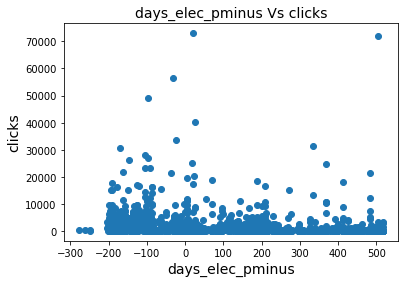

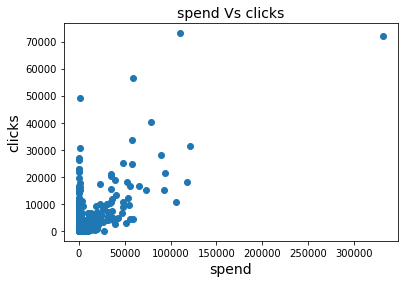

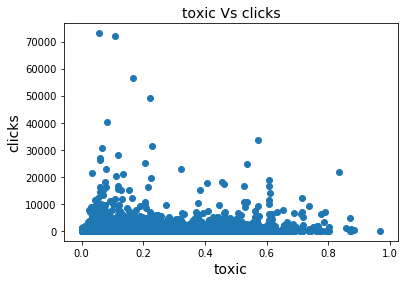

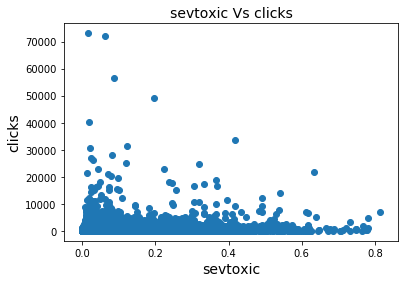

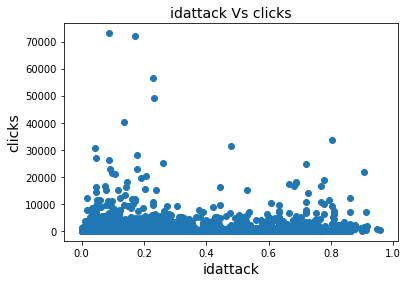

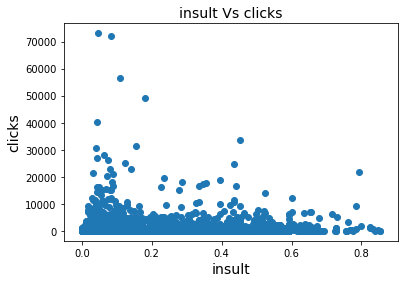

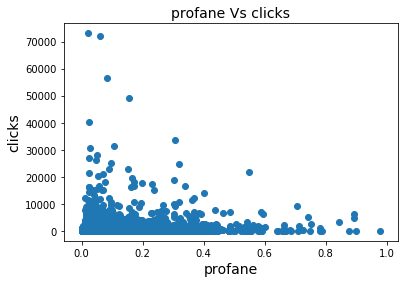

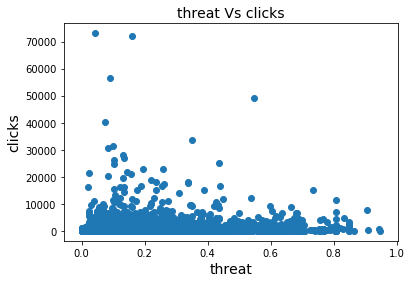

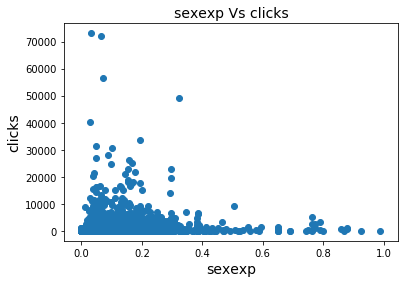

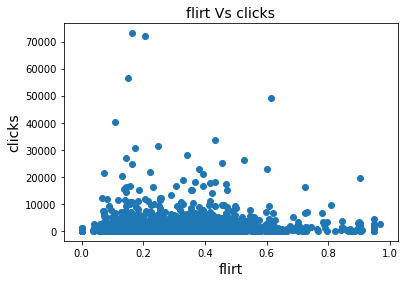

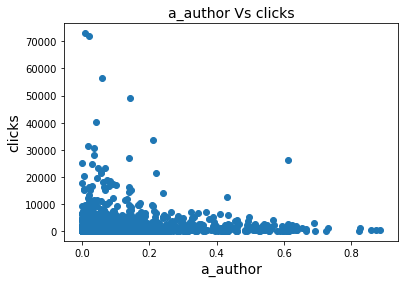

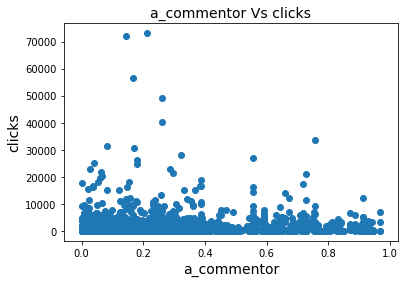

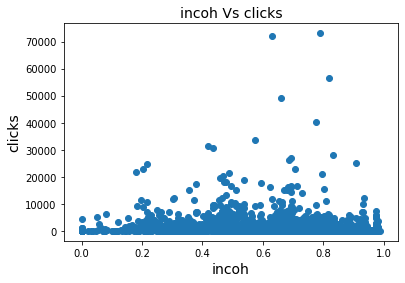

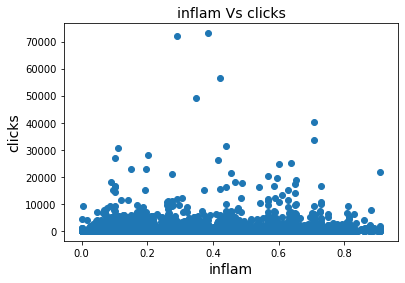

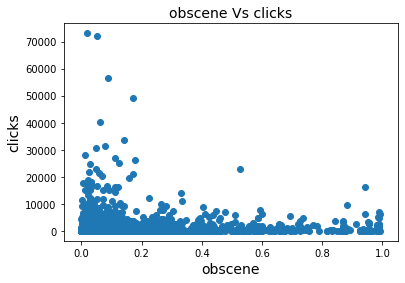

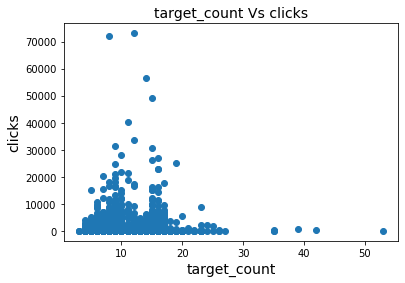

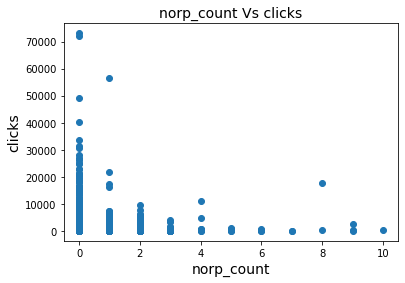

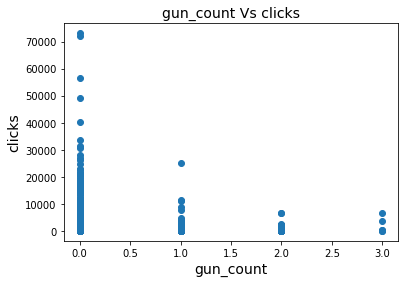

In [0]:
# Next, we do a scatter plot on each of the feature
from pandas import DataFrame
import matplotlib.pyplot as plt

for predictor_name in list_of_predictor_names:
  plt.scatter(final_df[predictor_name], target_df)
  plt.title('{} Vs {}'.format(predictor_name, target_name), fontsize=14)
  plt.ylabel(target_name, fontsize=14)
  plt.xlabel(predictor_name, fontsize=14)
  plt.show()


After doing the scatter plot, we can see there is no linear relationship b/w clicks and the selected features

In [0]:
# Next we look at the correlation b/w the target and predictors

corrs_with_target = []
for predictor_name in list_of_predictor_names:
  correlation_of_predictor_to_target = final_df[predictor_name].corr(final_df[target_name])
  corrs_with_target.append(correlation_of_predictor_to_target)

predictor_correlation_with_target_matrix = pd.DataFrame(list_of_predictor_names)
predictor_correlation_with_target_matrix.columns = ['predictor_name']

predictor_correlation_with_target_matrix['correlation_with_clicks'] = corrs_with_target
print(predictor_correlation_with_target_matrix.sort_values(by=['correlation_with_clicks'], ascending=False))


      predictor_name  correlation_with_clicks
1              spend                 0.653975
15      target_count                 0.106006
11       a_commentor                 0.056301
10          a_author                 0.028104
14           obscene                -0.008055
13            inflam                -0.014028
17         gun_count                -0.016979
9              flirt                -0.033895
12             incoh                -0.038504
16        norp_count                -0.038644
8             sexexp                -0.042254
3           sevtoxic                -0.053113
7             threat                -0.064130
6            profane                -0.064997
2              toxic                -0.065747
5             insult                -0.077029
4           idattack                -0.077088
0   days_elec_pminus                -0.146342


As we can see from above correlation b/w the target and predictors, we see that only one feature "spend" seems to be mostly correlated to "click".

In [0]:
# Here, we split the data based on the requirement:
#   "The extent to which the data is split as instructed in the rubric.
#   70% of the data for training, test on 20% of the data, holdout 10%, perform prediction on the holdout set"

# To do three-way split, we use train_test_split twice as done in https://stackoverflow.com/a/42932524
from sklearn.model_selection import train_test_split

training_percentage = 70.0/100.0
testing_percentage = 20.0/100.0
holdout_percentage = 10.0/100.0

intermediate_percentage = 1.0 - testing_percentage
x_intermediate, x_test, y_intermediate, y_test = train_test_split(predictors_df, target_df,
                                                                  test_size=testing_percentage,
                                                                  train_size=intermediate_percentage,
                                                                  random_state=1)

x_train, x_holdout, y_train, y_holdout = train_test_split(x_intermediate, y_intermediate,
                                                          test_size=(holdout_percentage/intermediate_percentage),
                                                          train_size=(training_percentage/intermediate_percentage),
                                                          random_state=1)

x_y_dataset_by_type = {
    "train": (x_train, y_train),
    "test": (x_test, y_test),
    "holdout": (x_holdout, y_holdout)
}
# This is to confirm our above calculation did indeed partition the dataset properly based on the given percentage
print("total size:", len(predictors_df), len(target_df))
for datasettype, dataset in x_y_dataset_by_type.items():
  print("size of datasettype: {} x:{} y:{}".format(datasettype, len(dataset[0]), len(dataset[1])))


total size: 2603 2603
size of datasettype: train x:1821 y:1821
size of datasettype: test x:521 y:521
size of datasettype: holdout x:261 y:261


In [0]:
# Defining a function that fits a given model and does prediction, gets r2, MSE
# for each type of dataset
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict

RECOMMENDED_CV = 5    # This is the CV recommended in the project guidelines

def fit_model_and_get_results(model):
  # fit the model using training set only
  model.fit(x_train, y_train)

  # get the coefficient for each predictor
  predictor_coefficients = pd.DataFrame(list_of_predictor_names)
  predictor_coefficients.columns = ['predictor_name']
  predictor_coefficients['predictor_coeff'] = model.coef_
  predictor_coefficients = predictor_coefficients.sort_values(by=['predictor_coeff'], ascending=False)

  # get prediction across all datasets
  prediction_by_datasettype = {}
  for datasettype, dataset in x_y_dataset_by_type.items():
    x = dataset[0]
    prediction_y = model.predict(x)
    prediction_by_datasettype[datasettype] = prediction_y

  # get r-square across all datasets
  r2_by_datasettype = {}
  for datasettype, dataset in x_y_dataset_by_type.items():
    x = dataset[0]
    y = dataset[1]
    r2 = model.score(x, y)
    r2_by_datasettype[datasettype] = r2

  # get mean-squared-error across all datasets
  mean_squared_error_by_datasettype = {}
  for datasettype, dataset in x_y_dataset_by_type.items():
    y = dataset[1]
    mse = mean_squared_error(y, prediction_by_datasettype[datasettype])
    mean_squared_error_by_datasettype[datasettype] = mse


  # make cross validated predictions and calculate cross-validation r2
  cv_r2_score_by_datasettype = {}
  for datasettype, dataset in x_y_dataset_by_type.items():
    x = dataset[0]
    y = dataset[1]
    cv_predictions = cross_val_predict(model, x, y, cv=RECOMMENDED_CV)
    cv_r2_score = r2_score(y, cv_predictions)
    cv_r2_score_by_datasettype[datasettype] = cv_r2_score
  
  return predictor_coefficients, r2_by_datasettype, cv_r2_score_by_datasettype, mean_squared_error_by_datasettype, prediction_by_datasettype


# A function that plots dataset with prediction
def plot_dataset_with_prediction(datasettype, x, y, predicted_y):
  plt.scatter(x, y, color = 'red', label="x vs y")
  plt.plot(x, predicted_y, color = 'blue', label="x vs prediction")
  plt.title('{} vs {} ({} set)'.format(x.name, y.name, datasettype))
  plt.legend()
  plt.xlabel(x.name)
  plt.ylabel(y.name)
  plt.show()

print("Functions created")

Functions created


In [0]:
# Run various models and get the results of model runs
from sklearn.linear_model import (
    ElasticNetCV, LinearRegression, LassoLarsCV,
    LassoCV)

# Following are the models we will compare
models_by_name = {
    "ElasticNetCV": ElasticNetCV(cv=RECOMMENDED_CV),
    "LinearRegression": LinearRegression(),
    "LassoCV": LassoCV(cv=RECOMMENDED_CV),
    "LassoLarsCV": LassoLarsCV(cv=RECOMMENDED_CV),
}

for name, model in models_by_name.items():
  predictor_coefficients, r2_by_datasettype, cv_r2_score_by_datasettype, mean_squared_error_by_datasettype, prediction_by_datasettype = fit_model_and_get_results(model)
  print("\n\nFor Model {}".format(name))
  print("predictor_coefficients:\n{}".format(predictor_coefficients))
  print("r2_by_datasettype", r2_by_datasettype)
  print("cv_r2_score_by_datasettype", cv_r2_score_by_datasettype)
  print("mean_squared_error_by_datasettype", mean_squared_error_by_datasettype)





For Model ElasticNetCV
predictor_coefficients:
      predictor_name  predictor_coeff
1              spend         0.226502
9              flirt         0.000000
16        norp_count         0.000000
15      target_count         0.000000
14           obscene         0.000000
13            inflam        -0.000000
12             incoh        -0.000000
11       a_commentor         0.000000
10          a_author         0.000000
17         gun_count        -0.000000
8             sexexp         0.000000
7             threat        -0.000000
6            profane        -0.000000
5             insult        -0.000000
4           idattack        -0.000000
3           sevtoxic        -0.000000
2              toxic        -0.000000
0   days_elec_pminus        -2.027782
r2_by_datasettype {'train': 0.44101436810256434, 'test': 0.4632361029062222, 'holdout': 0.5291475084299633}
cv_r2_score_by_datasettype {'train': 0.43635781110792926, 'test': 0.45442675598643756, 'holdout': 0.5921977578472999}
mea

For model LassoLarsCV, scatter plot of prediction vs actual


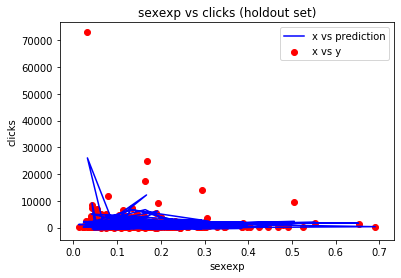

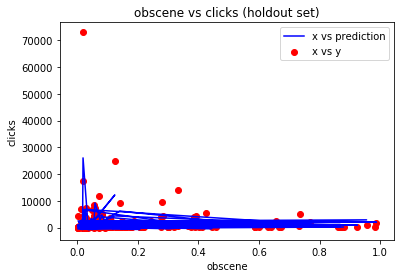

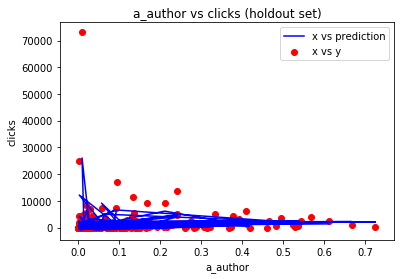

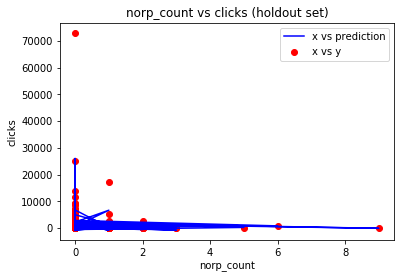

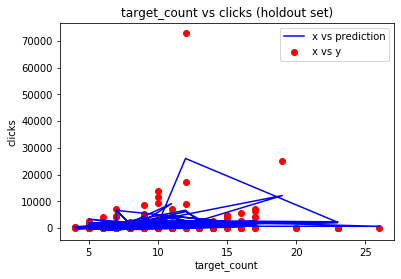

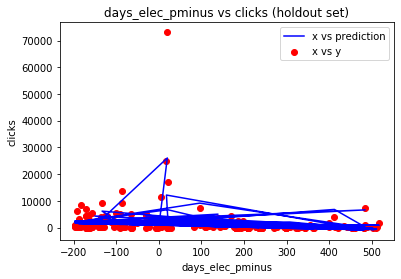

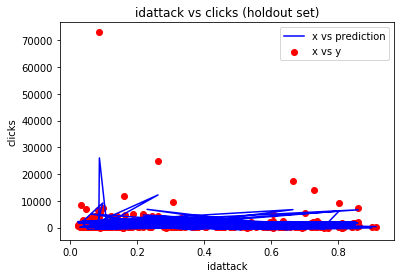

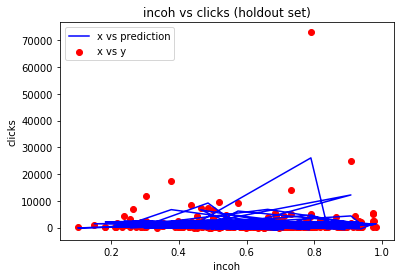

In [0]:
# Finally comparing the above results of all the models, I picked LassoLarsCV

# Here I try to draw the scatter plot of the prediction vs actual result for holdout dataset
# using LassoLarsCV

print("For model {}, scatter plot of prediction vs actual".format(name))
datasettype = "holdout"
predicted_y = prediction_by_datasettype[datasettype]
x, y = x_y_dataset_by_type[datasettype]
for i, row in predictor_coefficients.iterrows():
  predictor_name = row['predictor_name']
  coeff = row['predictor_coeff']
  if int(abs(coeff)) != 0:
    plot_dataset_with_prediction(datasettype, x[predictor_name], y, predicted_y)


In [0]:
# Just for clarity, following is the final R2 value of the selected model (LassoLarsCV) by datasettype
print("For model {}, R2 value by datasettype: {}".format(name, r2_by_datasettype))


For model LassoLarsCV, R2 value by datasettype: {'train': 0.4611364456863407, 'test': 0.4747624527836395, 'holdout': 0.5334391452779166}
